In [ ]:
### Activate virtual environment with bash

"""
cd flowers_classifier
python3 -m venv venv
. venv/bin/activate
pip install requirements.txt
"""

In [25]:
# Import modules

from collections import OrderedDict
import json

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from PIL import Image
import torch
from torch import nn
from torch import optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch.optim import lr_scheduler
from torch.autograd import Variable

In [26]:
# Jupyter configuration

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [27]:
# Set names

data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [28]:
# Define transforms for training, validation, and testing datasets

data_transforms = {
    'train' : transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),transforms.RandomRotation(30),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], 
                                                         [0.229, 0.224, 0.225])]),
                                                            
    'valid' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])]),

    'test' : transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], 
                                                           [0.229, 0.224, 0.225])])
}

In [29]:
# Load and transform datasets

image_datasets = {
    'train' : datasets.ImageFolder(train_dir, transform=data_transforms['train']),
    'test' : datasets.ImageFolder(test_dir, transform=data_transforms['test']),
    'valid' : datasets.ImageFolder(valid_dir, transform=data_transforms['valid'])
}

In [30]:
# Define data loaders

dataloaders = {
    'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size=64, shuffle=True),
    'test' : torch.utils.data.DataLoader(image_datasets['test'], batch_size=64, shuffle=False),
    'valid' : torch.utils.data.DataLoader(image_datasets['valid'], batch_size=64, shuffle=True)
}

In [31]:
# Define class to index mapping for training dataset

## key = directory
## value = index of directory

class_to_idx = image_datasets['train'].class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

In [32]:
# Load mapping for label to name from json

with open('class_to_name.json', 'r') as f:
    class_to_name = json.load(f)

In [33]:
# Test class_to_idx mapping

class_ = '34'  # should be pink primrose

print(f'''
Class Directory: {class_}
Class Index: {class_to_idx[class_]}
Class Name: {class_to_name[class_]}
''')


Class Directory: 34
Class Index: 30
Class Name: mexican aster



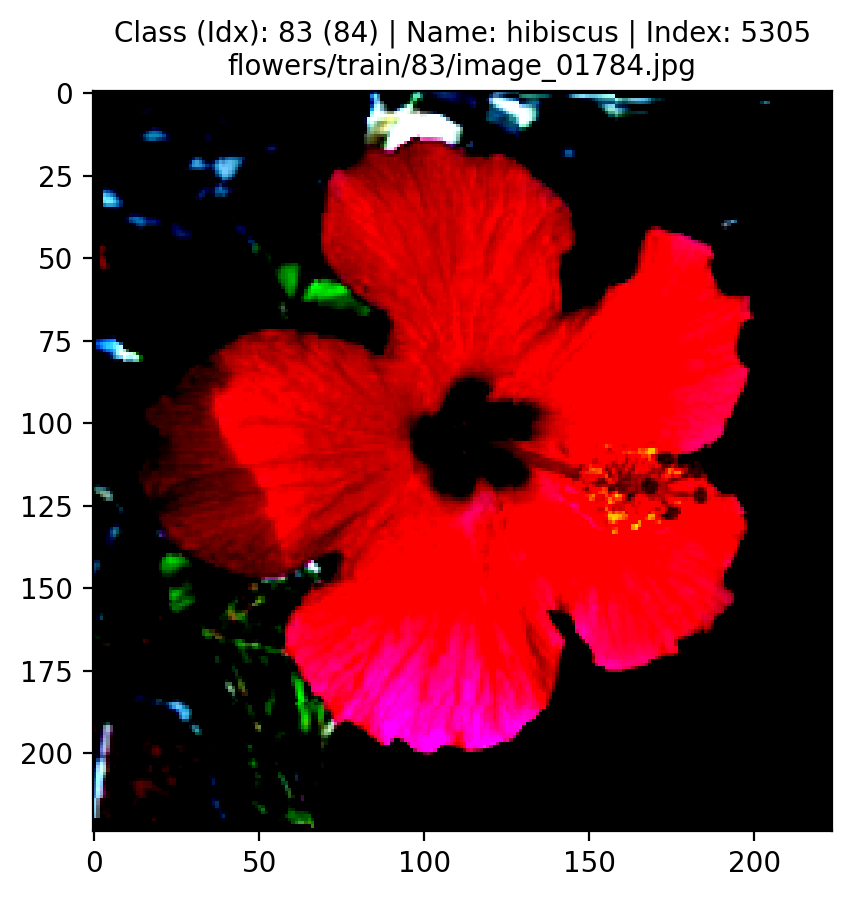

{'class': '83', 'class_index': 84, 'class_name': 'hibiscus', 'image_path': 'flowers/train/83/image_01784.jpg', 'image_index': 5305}


In [34]:
# Test mapping by image index or random image

from image_utils import inspect_image

image_metadata = inspect_image(
    dataset_name='train',
    dataloaders=dataloaders,
    class_to_idx=class_to_idx,
    class_to_name=class_to_name,
    # image_idx=255  # optional
    plot=True
)

print(image_metadata)

In [35]:
# Load model from checkpoint

### This didn't work, something about cuda

# def load_checkpoint(filepath):
#     checkpoint = torch.load(filepath)
#     model = models.vgg13(pretrained = True)
#     model.state_dict = checkpoint['state_dict']
#     model.classifier = checkpoint['classifer']
#     # model.classifier = checkpoint['classifier']    # it should be this fix me later
#     model.class_to_idx = checkpoint['class_to_idx']
    
#     return model

In [36]:
# Model

import torch.nn as nn

# Simple Neural Network
class SimpleNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_size = 3 * 224 * 224       # Assuming 64x64 RGB images
num_classes = len(image_datasets['train'].classes)

model = SimpleNN(input_size, num_classes)
print(model)


SimpleNN(
  (fc1): Linear(in_features=150528, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=102, bias=True)
  (relu): ReLU()
)


In [37]:
# Training loop

import torch.optim as optim

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in dataloaders['train']:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(dataloaders['train'].dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f}")


Epoch [1/5] Loss: 18.1518
Epoch [2/5] Loss: 9.4266
Epoch [3/5] Loss: 8.1821
Epoch [4/5] Loss: 7.4361
Epoch [5/5] Loss: 7.1327


In [38]:
# Evaluation

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in dataloaders['valid']:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy on validation set: {100 * correct / total}%')


Accuracy on validation set: 3.7897310513447433%


In [24]:
torch.save(model.state_dict(), 'smooth_brain_model.pth')

# To load the model later:
# model.load_state_dict(torch.load('simple_model.pth'))
